In [1]:
# I Colab 에서 실행할때는 ,  empiricaldist 설치
# https://pypi.org/project/empiricaldist/
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

이전 장에서는 베이즈 정리를 사용하여 쿠키 문제를 해결하고, 그런 다음 베이즈 테이블을 사용하여 다시 해결했습니다. 이번 장에서는 "확률 질량 함수"를 나타내는 Pmf 객체를 사용하여 한 번 더 문제를 해결할 것입니다. 이것이 무엇을 의미하며, 왜 베이지안 통계에 유용한지 설명하겠습니다.
PMF = Probability Mass Function 

우리는 Pmf 객체를 사용하여 좀 더 어려운 문제를 해결하고 베이지안 통계로 한 단계 더 나아갈 것입니다. 그러나 우리는 분포부터 시작하겠습니다.

## 분포(Distribution)
통계학에서 **분포(Distribution)**는 가능한 결과(outcome)들과 그에 해당하는 확률들의 집합입니다. 예를 들어, 동전을 던질 경우, 거의 동등한 확률로 두 가지 가능한 결과가 있습니다. 여섯 면 주사위를 굴릴 경우, 가능한 결과 집합은 1부터 6까지의 숫자이며, 각 결과와 관련된 확률은 1/6입니다.

분포를 나타내기 위해 empiricaldist라는 라이브러리를 사용할 것입니다. "경험적" 분포는 이론적인 분포 대신 데이터에 기반한 분포를 의미합니다. 이 라이브러리는 이 책 전체에서 사용될 것이며, 이 장에서 기본 기능을 소개하고 나중에 추가 기능을 살펴볼 것입니다.

## Probability Mass Functions

만약 분포의 결과가 이산적인 경우, 확률 질량 함수(Probability Mass Function, PMF)를 사용하여 분포를 설명할 수 있습니다. PMF는 각 가능한 결과에서 해당하는 확률로 매핑하는 함수입니다.

empiricaldist는 확률 질량 함수를 나타내는 Pmf 클래스를 제공합니다. Pmf를 사용하려면 다음과 같이 가져와서 사용할 수 있습니다:

In [3]:
from empiricaldist import Pmf

다음 예제는 동전 던지기의 결과를 나타내는 Pmf를 생성합니다. 코드는 다음과 같습니다:

In [4]:
coin =Pmf()
coin['heads'] =1/2
coin['tails']=1/2
coin

,probs
heads,0.5
tails,0.5


`Pmf`는 아무 결과도 가지지 않은 빈 `Pmf`를 생성하며, 이후에 대괄호 연산자를 사용하여 새로운 결과를 추가할 수 있습니다. 이 예제에서는 두 가지 결과가 문자열로 표시되며, 두 결과 모두 0.5의 확률을 가집니다.

`Pmf` 를 가능한 결과의 시퀀스에서 만들 수도 있습니다.

다음 예제에서는 `Pmf.from_seq`를 사용하여 6면 주사위를 나타내는 `Pmf`를 만듭니다. 코드는 다음과 같습니다:

이 예제에서는 시퀀스 내의 모든 결과가 한 번씩 나타나므로 모든 결과는 동일한 확률인 $1/6$을 가집니다.

보다 일반적으로, 결과는 다음 예제와 같이 한 번 이상 나타날 수 있습니다:

문자 `M`은 11자 중 한 번 나타나므로 확률은 $1/11$입니다.
문자 'i'가 4번 나타나므로 확률은 $4/11$입니다.

문자열의 문자는 무작위 프로세스의 결과가 아니므로 `Pmf`의 문자에 대해 보다 일반적인 용어인 "수량"을 사용하겠습니다.

`Pmf` 클래스는 Pandas `Series`에서 상속되므로 `Series`로 수행할 수 있는 모든 작업은 `Pmf`로도 수행할 수 있습니다.

예를 들어 대괄호 연산자를 사용하여 수량을 조회하고 해당 확률을 얻을 수 있습니다. 

"Mississippi"라는 단어에서는 글자의 약 36%가 "s"입니다.

그러나 분포에 없는 수량의 확률을 묻는 경우 'KeyError'가 발생합니다.

괄호를 사용하면 연속된 갯수를  제공하고 연속된 확률을 얻을 수도 있습니다.

$$ P(3 \lt X \le 4 ) =>  F_{X}(4) - F_{X}(3) $$

## 쿠키 문제 재검토

이 섹션에서는 `Pmf`를 사용하여 <<_TheCookieProblem>>의 쿠키 문제를 해결하겠습니다.
문제의 진술은 다음과 같습니다.

> 쿠키 두 그릇이 있다고 가정해 보세요.
>
> * 그릇 1에는 바닐라 쿠키 30개, 초코 쿠키 10개가 들어있습니다.
>
> * 그릇 2에는 바닐라 쿠키 20개, 초코 쿠키 20개가 들어있습니다.
>
> 이제 그릇 중 하나를 무작위로 선택하고 보지 않고 무작위로 쿠키를 선택한다고 가정해 보겠습니다. 쿠키가 바닐라라면 그릇 1에서 나왔을 확률은 얼마입니까?

다음은 두 가지 가설과 사전 확률을 나타내는 `Pmf`입니다.

In [5]:
prior =Pmf.from_seq(['Bowl 1','Bowl 2'])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


각 가설에 대한 사전 확률을 포함하는 이 분포를 **사전(prior)  분포**라고 합니다.

새로운 데이터(바닐라 쿠키)를 기반으로 분포를 업데이트하려면,
사전에 가능성(likelihood) 을 곱합니다. 
Bowl  1에서 바닐라 쿠키를 선택하는 likelihood는   '3/4'이고 Bowl 2에서 바닐라 쿠키를 선택하는   likelihood는  '1/2'입니다.

In [6]:
likelihood_vanilla =[0.75,0.5]
posterior = prior *likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


데이터의 likelihood 는 각 그릇에 담긴 바닐라 쿠키의 비율이며, `hypos`를 사용하여 계산할 수 있습니다. 

결과는 정규화되지 않은 posterior 입니다. 즉, 합이 1이 되지 않습니다.
이를 1이 되도록 하려면  `Pmf`에서 제공하는 방법인 `normalize`를 사용하면 됩니다.

In [7]:
posterior.normalize()

0.625

'normalize'의 반환 값은 데이터의 총 확률이며 $5/8$입니다.

각 가설에 대한 사후 확률을 포함하는 'posterior'를  **사후 분포**라고 합니다.

In [8]:
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


사후 분포에서 Bowl 1에 대한 사후 확률을 선택할 수 있습니다.

In [9]:
posterior('Bowl 1')

0.6

그리고 답은 0.6입니다.

`Pmf` 개체를 사용하면 더 많은 데이터로 연속적인 업데이트를 쉽게 수행할 수 있다는 이점이 있습니다.
예를 들어, 첫 번째 쿠키를 다시 넣고(그릇의 내용물이 변하지 않도록) 동일한 그릇에서 다시 선택합니다 
두 번째 쿠키도 바닐라인 경우 다음과 같이 두 번째 업데이트를 수행할 수 있습니다.

$$ P(\theta | X) = \frac{P(X|\theta)P(\theta)}{P(X)}  $$

In [10]:
posterior*= likelihood_vanilla #사후 확률은 이전의 사후확률이 사전확률이 되어
#likelihood와 곱한다 ,갱신 
posterior.normalize() #정규화
posterior #더한 결과가 1이된다 

,probs
Bowl 1,0.692308
Bowl 2,0.307692


이제 그릇 1의 사후 확률은 거의 70%입니다.
하지만 같은 일을 다시 해서 초콜릿 쿠키를 얻었다고 가정해 보세요.

새 데이터의 가능성은 다음과 같습니다.

In [11]:
likelihood_chocolate =[0.25,0.5]

In [12]:
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


이제 그릇 1의 사후 확률은 약 53%입니다.
바닐라 쿠키 2개와 초콜릿 1개 이후의 사후 확률은 50/50에 가깝습니다.

## 101그릇

다음으로 101개의 그릇으로 쿠키 문제를 해결해 보겠습니다.

* 그릇 0에는 바닐라 쿠키 0%가 들어 있으며,

* 그릇 1에는 바닐라 쿠키 1%가 들어있고,

* 그릇 2에는 바닐라 쿠키 2%가 들어있고,

등등, 최대

*  99번째의  그릇 에는 바닐라 쿠키가 99% 함유되어 있으며,

* 100 번째 그릇에는 바닐라 쿠키가 모두 들어있습니다.

이전 버전과 마찬가지로 쿠키는 바닐라와 초콜렛 두 종류만 존재합니다. 따라서 그릇 0은 모두 초콜릿 쿠키이고 그릇 1은 99% 초콜릿입니다.

그릇을 무작위로 선택하고, 쿠키도 무작위로 선택했는데, 결과적으로 바닐라가 나왔다고 가정해 보겠습니다. $x$의 각 값에 대해 쿠키가 Bowl $x$에서 나올 확률은 얼마입니까?

이 문제를 해결하기 위해 'np.arange'를 사용하여 0부터 100까지 번호가 매겨진 101개의 가설을 나타내는 배열을 만듭니다.

In [13]:
import numpy as np

In [14]:
hypos =np.arange(101)

사전 확률을 생성하기 위해  배열 사용

In [15]:
prior = Pmf(1, hypos)
prior.normalize()

101

이 예에서 볼 수 있듯이 두 개의 매개변수를 사용하여 `Pmf`를 초기화할 수 있습니다.
첫 번째 매개변수는 사전 확률입니다. 두 번째 매개변수는 일련의 수량입니다.

이 예에서는 확률이 모두 동일하므로 그 중 하나만 제공하면 됩니다. 그것은 hypotheses  전반에 걸쳐 "broadcast"됩니다.
모든 가설은 동일한 사전 확률을 가지므로 이 분포는 **균일(uniform)**합니다.

처음 몇 가지 가설과 확률은 다음과 같습니다.

In [16]:
likelihood_vanilla = hypos/100
likelihood_vanilla[:5]

array([0.  , 0.01, 0.02, 0.03, 0.04])

In [17]:
posterior1 = prior*likelihood_vanilla
posterior1.normalize()
posterior1.head()

,probs
0,0.000000
1,0.000198
2,0.000396


하나의 바닐라 쿠기후에 사전 분포와 사후 분포의 그림 그리기

In [18]:
from utils import decorate

In [19]:
def decorate_bowls(title):
    decorate(xlabel='Bowl #' ,ylabel ='PMF' ,title=title)    

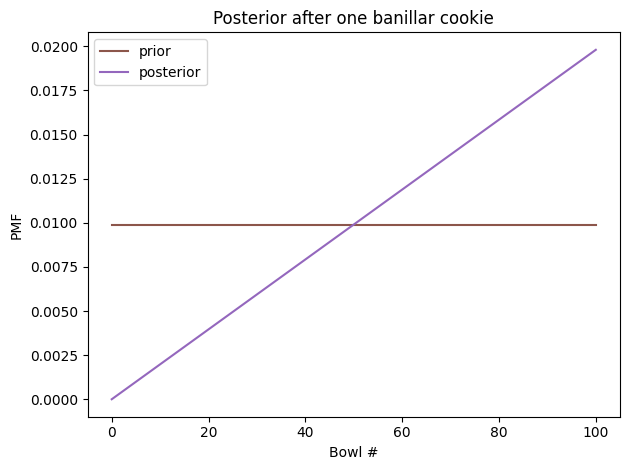

In [20]:
prior.plot(label='prior',color='C5')
posterior1.plot(label='posterior',color='C4')
decorate_bowls('Posterior after one banillar cookie')

그릇 0의 사후 확률은 바닐라 쿠키가 포함되어 있지 않기 때문에 0입니다.
바닐라 쿠키가 가장 많이 포함되어 있는 그릇 100의 사후 확률이 가장 높습니다.
그 사이에서 우도는 그릇 수에 비례하므로 사후 분포의 모양은 선입니다.

이제 쿠키를 다시 넣고 같은 그릇에서 다시 꺼내서 또 다른 바닐라 쿠키를 얻는다고 가정해 보겠습니다.
두 번째 쿠키 이후의 업데이트는 다음과 같습니다.

In [21]:
posterior2 = posterior1*likelihood_vanilla
posterior2.normalize()

0.6699999999999999

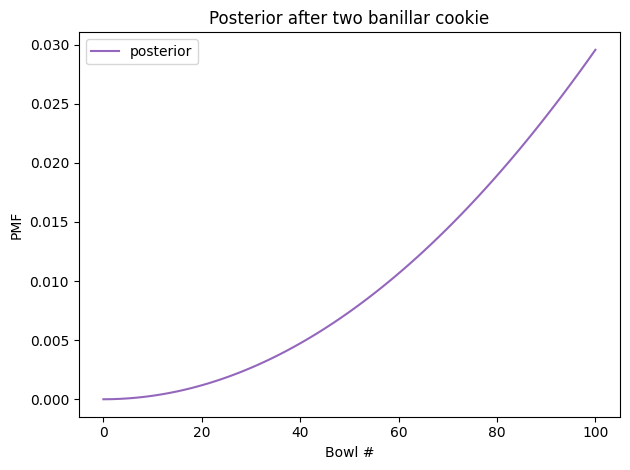

In [22]:
posterior2.plot(label='posterior',color='C4')
decorate_bowls('Posterior after two banillar cookie')

두 개의 바닐라 쿠키 다음에는 숫자가 높은 그릇에 바닐라 쿠키가 가장 많이 포함되어 있으므로 사후 확률이 가장 높습니다. 낮은 번호의 그릇은 확률이 가장 낮습니다.

하지만 다시 그림을 그려 초콜릿 쿠키를 얻었다고 가정해 보겠습니다.
업데이트는 다음과 같습니다.

In [23]:
likelihood_chocolate = 1- hypos/100
posterior3 = posterior2 *likelihood_chocolate
posterior3.normalize()

0.2462686567164179

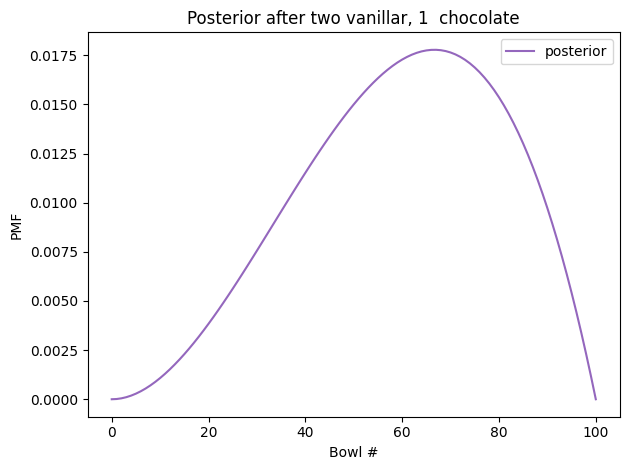

In [24]:
posterior3.plot(label='posterior',color='C4')
decorate_bowls('Posterior after two vanillar, 1  chocolate')

이제 Bowl 100에는 초콜릿 쿠키가 포함되어 있지 않기 때문에 제거되었습니다.
그러나 숫자가 높은 그릇이 낮은 그릇보다 더 가능성이 높습니다. 왜냐하면 우리가 초콜릿보다 바닐라 쿠키를 더 많이 봤기 때문입니다.

실제로 사후 분포의 정점은 Bowl 67에 있으며, 이는 우리가 관찰한 데이터에서 바닐라 쿠키의 비율인 $2/3$에 해당합니다.

사후 확률이 가장 높은 수량을 **MAP**이라고 하며 이는 "최대 사후 확률(Maximum a Posterior)"을 의미합니다. 여기서 "사후"는 "사후"를 뜻하는 불필요한 라틴어입니다.

MAP을 계산하려면 `Series` 메서드 `idxmax`를 사용할 수 있습니다.

최대 우도 추정(MLE/Maximum Likelihood Estimation )에서는 데이터 세트를 생성할 확률을 최대화하는 분포를 추정하는 것을 의미합니다. 이 글에서는 이를 데이터로부터의 분포(distribution) 추론(inference) 을 위한 일반적인 프레임워크로 정의하고 이를 여러 종류의 데이터 분포에 적용할 것입니다. 이 방법은 실험 데이터에 대해 신경망을 학습 할 때 사용할 최적의 손실 함수(optimal loss function) 를 결정하는 데 사용할 수 있습니다.

<img src='./images/4.JPG'/>

$$ \hat{\theta} = \underset{{ \overrightarrow{ \theta} } } {argmax} \prod_{i=1}^{N}p(x_{i}| \overrightarrow{\theta}) $$

In [25]:
posterior3.idxmax() #posterior가 가장큰 index가 몇번쨰인가 

67

짐작할 수 있듯이 이 예는 실제로 그릇에 관한 것이 아닙니다. 비율을 추정하는 것입니다.
쿠키 한 그릇이 있다고 상상해보십시오.
당신은 쿠키의 어느 부분이 바닐라인지 모르지만 그것이 0에서 1 사이의 어떤 부분일 가능성이 동일하다고 생각합니다.
쿠키 3개를 그렸는데 2개가 바닐라라면, 그릇에 있는 쿠키 중 바닐라는 몇 퍼센트나 될까요?
방금 계산한 사후 분포가 해당 질문에 대한 답입니다.

다음 장에서 비율 추정으로 다시 돌아오겠습니다.
하지만 먼저 'Pmf'를 사용하여 주사위 문제를 해결해 보겠습니다.

## 주사위 문제

이전 장에서는 베이즈 테이블을 사용하여 주사위 문제를 해결했습니다.
문제의 설명은 다음과 같습니다.

> 6면체 주사위, 8면체 주사위, 12면체 주사위가 있는 상자가 있다고 가정해 보겠습니다.
> 주사위 중 하나를 무작위로 선택하여 굴려서 결과가 1이라고 보고합니다.
> 내가 6면체 주사위를 선택할 확률은 얼마나 되나요?

`Pmf`를 사용하여 문제를 해결해 보겠습니다.
가설을 표현하기 위해 정수를 사용하겠습니다.

In [26]:
hypos=[6,8,12]

In [27]:
prior = Pmf(1/3,hypos)
prior

,probs
6,0.333333
8,0.333333
12,0.333333


이전 예에서와 같이 사전 확률은 가설 전체에 걸쳐 전파됩니다.
`Pmf` 객체에는 두 가지 속성이 있습니다:

* `qs`에는 분포의 양이 포함됩니다.

* `ps`에는 해당 확률이 포함되어 있습니다.

In [39]:
prior.qs

array([ 6,  8, 12], dtype=int64)

In [40]:
prior.ps

array([0.33333333, 0.33333333, 0.33333333])

이제 업데이트를 수행할 준비가 되었습니다.
각 가설(hypothesis)에 대한 데이터의 가능성(likelihood)은 다음과 같습니다.

In [43]:
likelihood1 =  1/6,1/8,1/12

In [44]:
posterior = prior*likelihood1
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


6면 주사위의 사후 확률은 $4/9$입니다.

이제 동일한 주사위를 다시 굴려 7이 나왔다고 가정해 보겠습니다.
가능성은 다음과 같습니다.

In [45]:
likelihood2 = 0,1/8,1/12

6면체 주사위의 가능성은 0입니다. 6면체 주사위에서는 7이 나올 수 없기 때문입니다.
나머지 두 가지 가능성은 이전 업데이트와 동일합니다.

업데이트는 다음과 같습니다.

In [47]:
posterior *= likelihood2
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


1과 7이 나온 후 8면체 주사위가 나올 확률은 약 69%입니다.

## 주사위 업데이트 중

다음 함수는 이전 섹션의 업데이트보다 더 일반적인 버전입니다.

In [48]:
def update_dice(pmf, data):
    """
        새로운 데이터에 기반하여 pmf 갱신
    """
    hypos = pmf.qs
    likelihood = 1/hypos #분모가 크면 likelihood는 작아짐, 
    impossible=(data>hypos) 
    #결과가 주사위의 가상 면 수를 초과하는 경우 해당 결과가 나올 확률은 0입니다.
    #주사위를 굴린 결과가 hypos 보다 크면 impossible이 true가 되고
    likelihood[impossible]=0 #true가 된것에 0을 저장
    pmf*=likelihood
    pmf.normalize()

첫 번째 매개변수는 가능한 주사위와 확률을 나타내는 `Pmf`입니다.
두 번째 매개변수는 주사위를 굴린 결과입니다.

첫 번째 줄은 가설을 나타내는 `Pmf`에서 수량을 선택합니다.
가설(hypothesis)은 정수이므로 이를 사용하여 가능성을 계산할 수 있습니다.
일반적으로 주사위에 n개의 면이 있는 경우 가능한 결과가 나올 확률은 '1/n'입니다.

하지만, 불가능한 결과가 있는지 확인해야 합니다!
결과가 주사위의 가상 면 수를 초과하는 경우 해당 결과가 나올 확률은 0입니다.

'불가능'은 각각의 불가능한 결과에 대해 `True`인 'Boolean' `Series`입니다.
해당 확률을 0으로 설정하기 위해 이를 `가능성`에 대한 인덱스로 사용합니다.

마지막으로 `pmf`에 `likelihood`를 곱하고 정규화합니다.

이전 섹션에서 이 함수를 사용하여 업데이트를 계산하는 방법은 다음과 같습니다.
이전 배포판의 새로운 복사본으로 시작합니다.

In [49]:
pmf=prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


갱신하기 위해 `update_dice` 사용

In [50]:
update_dice(pmf,1)
update_dice(pmf,7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692


In [28]:
import sympy as sp
from sympy.plotting import plot

In [29]:
x,t = sp.symbols('x t')

In [30]:
f = x**2+(2/5)*x+(6/25)
f

x**2 + 0.4*x + 0.24

In [31]:
result=sp.integrate(f,(x,-1/5,t))
result-1

0.333333333333333*t**3 + 0.2*t**2 + 0.24*t - 0.957333333333333

In [32]:
sp.solve(result-1)[0]

1.10404517046408

In [33]:
5/3

1.6666666666666667

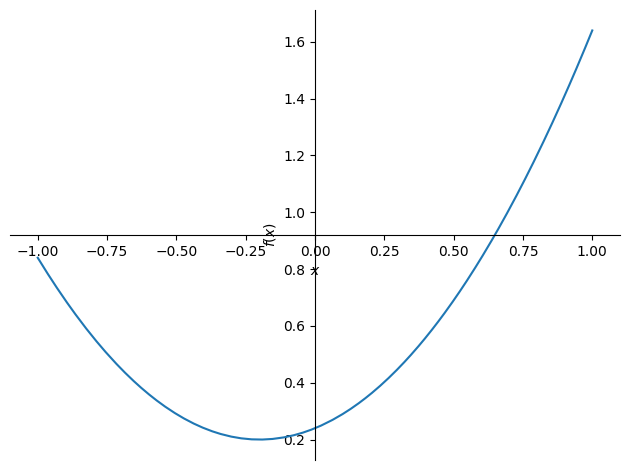

In [34]:
x,y = sp.symbols('x y')
y= x*x+(2/5)*x+(6/25)
plot(y,(x,-1,1))

In [35]:
t = sp.symbols('t')

In [36]:
sp.integrate(y,(x,-1/5,t))

0.333333333333333*t**3 + 0.2*t**2 + 0.24*t + 0.0426666666666667

In [37]:
solve_t=sp.integrate(y,(x,-1/5,t))-1
solve_t

0.333333333333333*t**3 + 0.2*t**2 + 0.24*t - 0.957333333333333

In [38]:
sp.solve(solve_t) # 3차 방정식 해가 3개, 하나는 실근, 두개는 허근

[1.10404517046408,
 -0.852022585232038 - 1.36945257492109*I,
 -0.852022585232038 + 1.36945257492109*I]